# How Route Choice can Impact Evacuation Times

This notebook can be directly downloaded {download}`here <./routing.ipynb>` to run it locally.

In this demonstration, we'll be simulating a room with a single exit. 
We'll place two distinct groups of agents in a designated zone within the room. 
Each group will be assigned a specific route to reach the exit: 
one group will follow the shortest path, while the other will take a longer detour.

To chart these paths, we'll use several waypoints, creating unique journeys for the agents to navigate.

## Configuring the Room Layout

For our simulation, we'll utilize a square-shaped room with dimensions of 20 meters by 20 meters. 
Inside, obstacles will be strategically placed to segment the room and guide both agent groups.

In [1]:
import pathlib

import jupedsim as jps
import matplotlib.pyplot as plt
import pedpy
import shapely
from matplotlib.patches import Circle
from shapely import Polygon

%matplotlib inline

In [28]:
complete_area = Polygon(
    [
        (0, 0),
        (0, 20),
        (40, 20),
        (40, 0),
    ]
)
obstacles = [
    Polygon(
        [
            (5, 4.0),
            (5, 16),
            (7, 16),
            (7, 4.0),
        ]
    ),
    Polygon(
        [
            (13, 4.0),
            (13, 16),
            (15, 16),
            (15, 4.0),
        ]
    ),
    Polygon(
        [
            (25, 4.0),
            (25, 16),
            (27, 16),
            (27, 4.0),
        ]
    ),
    Polygon(
        [
            (33, 4.0),
            (33, 16),
            (35, 16),
            (35, 4.0),
        ]
    ),
]

exit_polygon = [(19, 19), (20, 19), (20, 20), (19, 20)]
waypoints = [([3, 19], 3), ([7, 19], 2), ([7, 2.5], 2), ([17.5, 2.5], 2)]
distribution_polygons = [
    Polygon(
        [
            (2, 4.0),
            (2, 16),
            (5, 16),
            (5, 4.0),
        ]
    ),
    Polygon(
        [
            (15, 4.0),
            (15, 16),
            (18, 16),
            (18, 4.0),
        ]
    ),
    Polygon(
        [
            (22, 4.0),
            (22, 16),
            (25, 16),
            (25, 4.0),
        ]
    ),
    Polygon(
        [
            (35, 4.0),
            (35, 16),
            (38, 16),
            (38, 4.0),
        ]
    ),
]
obstacle = shapely.union_all(obstacles)
distribution_polygons = [
    shapely.intersection(distribution_polygon, complete_area) for distribution_polygon in distribution_polygons
]
walkable_area = pedpy.WalkableArea(shapely.difference(complete_area, obstacle))

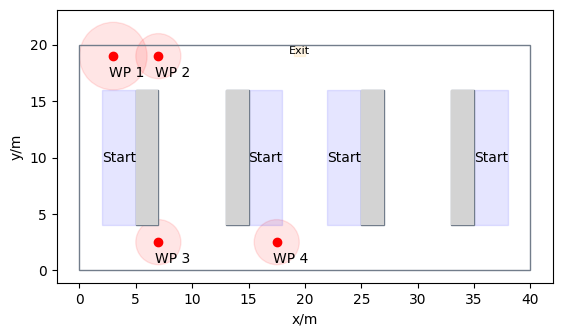

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_aspect("equal")
pedpy.plot_walkable_area(walkable_area=walkable_area, axes=ax)

for idx, (waypoint, distance) in enumerate(waypoints):
    ax.plot(waypoint[0], waypoint[1], "ro")
    ax.annotate(
        f"WP {idx + 1}",
        (waypoint[0], waypoint[1]),
        textcoords="offset points",
        xytext=(10, -15),
        ha="center",
    )
    circle = Circle(
        (waypoint[0], waypoint[1]), distance, fc="red", ec="red", alpha=0.1
    )
    ax.add_patch(circle)

x, y = Polygon(exit_polygon).exterior.xy
plt.fill(x, y, alpha=0.1, color="orange")
centroid = Polygon(exit_polygon).centroid
plt.text(centroid.x, centroid.y, "Exit", ha="center", va="center", fontsize=8)

for distribution_polygon in distribution_polygons:
    x, y = distribution_polygon.exterior.xy
    plt.fill(x, y, alpha=0.1, color="blue")
    centroid = distribution_polygon.centroid
    plt.text(centroid.x, centroid.y, "Start", ha="center", va="center", fontsize=10)

## Configuration of Simulation Scenarios
<a id="model"></a>
With our room geometry in place, the next step is to define the simulation object, the operational model and its corresponding parameters. In this demonstration, we'll use the "collision-free" model.

We'll outline an array of percentage values, allowing us to adjust the sizes of the two groups across multiple simulations. As a result, creating distinct simulation objects for each scenario becomes essential.

In [30]:
percentage = 0
total_agents = 20

trajectory_file = f"trajectories_percentage_{percentage}.sqlite"
simulation = jps.Simulation(
    dt=0.05,
    model=jps.CollisionFreeSpeedModel(
        strength_neighbor_repulsion=2.6,
        range_neighbor_repulsion=0.1,
        range_geometry_repulsion=0.05,
    ),
    geometry=walkable_area.polygon,
    trajectory_writer=jps.SqliteTrajectoryWriter(
        output_file=pathlib.Path(trajectory_file),
    ),
)

## Outlining Agent Journeys

Having established the base configurations, it's time to outline the routes our agents will take. 
We've designated two distinct pathways:

- The first route is a direct path, guiding agents along the shortest distance to the exit.
- The second route, in contrast, takes agents on a more extended journey, guiding them along the longest distance to reach the same exit.

These variations in routing are designed to showcase how agents navigate and respond under different evacuation strategies.

In [31]:
def set_journeys(simulation):
    exit_id = simulation.add_exit_stage(exit_polygon)
    waypoint_ids = []
    for waypoint, distance in waypoints:
        waypoint_ids.append(simulation.add_waypoint_stage(waypoint, distance))

    long_journey = jps.JourneyDescription([*waypoint_ids[:], exit_id])
    for idx, waypoint in enumerate(waypoint_ids):
        next_waypoint = (
            exit_id if idx == len(waypoint_ids) - 1 else waypoint_ids[idx + 1]
        )
        long_journey.set_transition_for_stage(
            waypoint, jps.Transition.create_fixed_transition(next_waypoint)
        )

    short_journey = jps.JourneyDescription([waypoint_ids[0], exit_id])
    short_journey.set_transition_for_stage(
        waypoint_ids[0], jps.Transition.create_fixed_transition(exit_id)
    )

    long_journey_id = simulation.add_journey(long_journey)
    short_journey_id = simulation.add_journey(short_journey)
    return short_journey_id, long_journey_id, waypoint_ids[0]

## Allocation and Configuration of Agents
<a id="distribution"></a>
With our environment set up, it's time to introduce and configure the agents, utilizing the parameters we've previously discussed. We're going to place agents in two distinct groups, the proportion of which will be determined by the specified percentage parameter.

- The first group will be directed to take the longer route to the exit.
- Conversely, the second group will be guided along the shortest path to reach the exit.

By doing so, we aim to observe and analyze the behaviors and dynamics between these two groups under varying evacuation strategies.

In [32]:
positions = jps.distribute_by_number(
    polygon=distribution_polygon,
    number_of_agents=total_agents,
    distance_to_agents=0.5,
    distance_to_polygon=0.7,
    seed=45131502,
)

**Reminder:**

Given that the journey operates as a graph, it's essential to designate the initial target for the agents by setting the `stage_id`.

## Launching the Simulations

Having  configured our environment, agents, and routes, we are now poised to set the simulation into motion. For the purposes of this demonstration, agent trajectories throughout the simulation will be systematically captured and stored within an SQLite database. This will allow for a detailed post-analysis of agent behaviors and movement patterns.

**Note**
Given that we've set the time step at $dt=0.05$ seconds and aim to restrict the simulation duration to approximately 2 minutes, we will cap the number of iterations per simulation to 3000.

In [ ]:
short_journey_id, long_journey_id, first_waypoint_id = set_journeys(
    simulation
)

num_items = int(len(positions) * (percentage / 100.0))

for position in positions[num_items:]:
    simulation.add_agent(
        jps.CollisionFreeSpeedModelAgentParameters(
            position=position,
            journey_id=short_journey_id,
            stage_id=first_waypoint_id,
        )
    )

for position in positions[:num_items]:
    simulation.add_agent(
        jps.CollisionFreeSpeedModelAgentParameters(
            position=position,
            journey_id=long_journey_id,
            stage_id=first_waypoint_id,
        )
    )

while simulation.agent_count() > 0 and simulation.iteration_count() < 3000:
    simulation.iterate()

trajectory_file = f"trajectories_percentage_{percentage}.sqlite"

## Visualizing Agent Pathways

To gain insights into the movement patterns of our agents, we'll visualize their trajectories. Data for this endeavor will be pulled directly from the SQLite database we've previously populated. 

In [36]:
from jupedsim.internal.notebook_utils import animate, read_sqlite_file

agent_trajectories = {}
agent_trajectories[percentage], walkable_area = read_sqlite_file(
    trajectory_file
)
animate(
    agent_trajectories[percentage],
    walkable_area,
    title_note=f"Percentage: {percentage}%",
).show()

In [46]:
evac_times = []
for percentage, traj in agent_trajectories.items():
    t_evac = traj.data["frame"].max() / traj.frame_rate
    evac_times.append(t_evac)

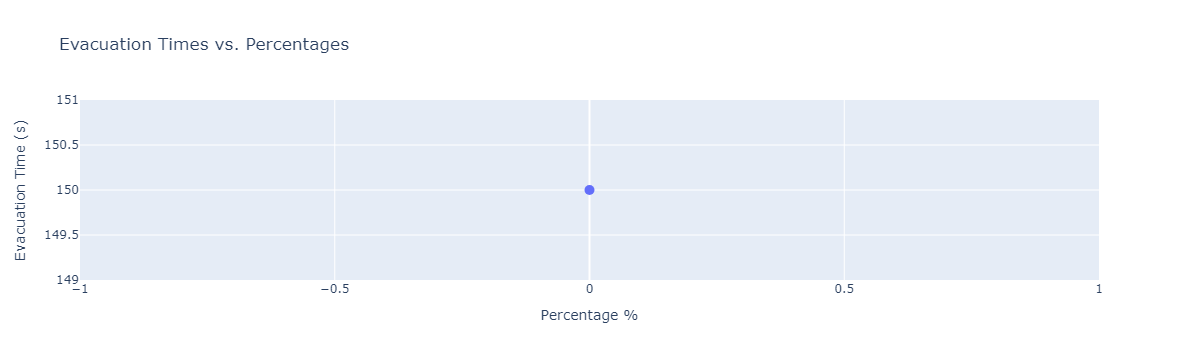

In [47]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=list(agent_trajectories.keys()),
        y=evac_times,
        marker=dict(size=10),
        mode="lines+markers",
        name="Evacuation Times",
    )
)

fig.update_layout(
    title="Evacuation Times vs. Percentages",
    xaxis_title="Percentage %",
    yaxis_title="Evacuation Time (s)",
)

fig.show()

## Summary and Discussion

In our simulated scenario, agents are presented with two distinct paths: a direct route that is shorter but prone to congestion and a detour. 
Given the high volume of individuals arriving at door 1, relying solely on one door's capacity proves impractical.

Although the alternate path through door 2 may be considerably longer in distance, it becomes crucial to utilize both doors in order to alleviate congestion and reduce waiting times at door 1.
The findings from our simulation align with this rationale. 

To optimize both average and peak arrival times, approximately 40% of individuals should choose the longer journey via door 2, which is in accordance with the results reported in this [paper](https://collective-dynamics.eu/index.php/cod/article/view/A24).
This strategic distribution ensures smoother flow dynamics and contributes towards enhancing evacuation efficiency.

Note, that in  we used a fixed seed number to distribute the agents. To get a reliable result  for this specific scenario, one should repeat the simulations many times for the sake of some statistical relevance.

Please note that in the section [Allocation and Configuration of Agents](#distribution), we employed a consistent seed number for agent distribution. For dependable outcomes, it's advised to run the simulations multiple times to ensure statistical significance. Morover, more percentage values between 0 and 100 will enhance the quality of the results.

# Download

This notebook can be directly downloaded {download}`here <./routing.ipynb>` to run it locally.